
Multi-GPU: Semantic Segmentation
=====================

Overview
----------------
1. Memahami struktur dataset cityscapes (https://www.cityscapes-dataset.com/)
2. Mendesain arsitektur sebuah model CNN encoder-decoder sederhana
3. Membuat beberapa fungsi pendukung (dataloader, train-val-test, dll)
4. Train-val-test model



INSPEKSI DATA
=====================


In [1]:
#Download data dari: https://www.cityscapes-dataset.com/downloads/

rootdir = "/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/"
dir_rgb = rootdir+"leftImg8bit_trainvaltest/leftImg8bit/"
dir_seg = rootdir+"gtFine_trainvaltest/gtFine/"
part = 'train/' #train val test
town = 'aachen/' #pilih salah satu kota

print(dir_rgb)
print(dir_seg)

/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/
/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/gtFine_trainvaltest/gtFine/


Part 1: visualisasi gambar dan inspeksi dimensi
----------------

(1024, 2048, 3)


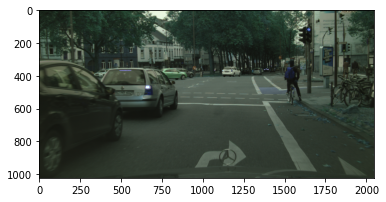

In [7]:
#import library yang diperlukan
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os

#list semua file yang ada pada salah satu town di direktori RGB
list_file = os.listdir(dir_rgb+part+town)
list_file.sort() #urutkan
idx = 10
filename = list_file[idx] #ambil salah satu file

#tampilkan
image = cv2.imread(dir_rgb+part+town+filename)
# image = image[:, :, [2, 1, 0]]
print(image.shape)
plt.imshow(image)
plt.show()

Part 2: load GT segmentation
----------------

(1024, 2048, 3)


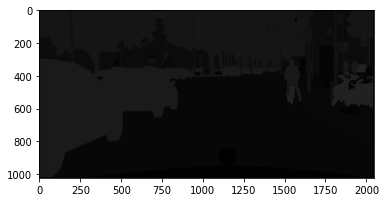

In [11]:
#list semua file yang ada pada salah satu town di direktori SEG
list_file = os.listdir(dir_seg+part+town)
list_file.sort() #urutkan
idx = 10
idx = 5*idx + 2
filename = list_file[idx] #ambil salah satu file

#tampilkan
seg_gt = cv2.imread(dir_seg+part+town+filename)
print(seg_gt.shape)
plt.imshow(seg_gt)
plt.show()


Part 3: visualisasi GT segmentation
----------------

In [12]:
#Define colormap dan konversi label dari 35 class ke 20 class
#BACA https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
SEG_MAP = {
    'colors'        :[[0, 0, 0], [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],  
                    [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
                    [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
                    [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], 
                    [0, 80, 100], [0, 0, 230], [119, 11, 32]],  
    'classes'       : ['None', 'road', 'sidewalk', 'building', 'wall',
                        'fence', 'pole', 'traffic light', 'traffic sign', 
                        'vegetation', 'terrain', 'sky', 'person', 
                        'rider', 'car', 'truck', 'bus',
                        'train', 'motorcycle', 'bicycle'],
}

mapping_20 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 2,
        9: 0,
        10: 0,
        11: 3,
        12: 4,
        13: 5,
        14: 0,
        15: 0,
        16: 0,
        17: 6,
        18: 0,
        19: 7,
        20: 8,
        21: 9,
        22: 10,
        23: 11,
        24: 12,
        25: 13,
        26: 14,
        27: 15,
        28: 16,
        29: 0,
        30: 0,
        31: 17,
        32: 18,
        33: 19,
        -1: 0
    }


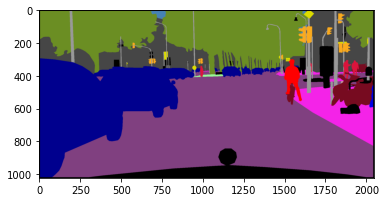

In [13]:
import numpy as np

#visualisasi segmentation
def vis_seg(seg, SEG_CMAP):
    #buat array kosong untuk menyimpan output gambar
    imgx = np.zeros((seg.shape[0], seg.shape[1], 3))
    #warnai setiap label
    for cmap in SEG_CMAP['colors']:
        cmap_id = SEG_CMAP['colors'].index(cmap)
        imgx[np.where(seg == cmap_id)] = cmap
#         imgx = imgx[:, :, [2, 1, 0]]
    return imgx

#konversi dari 35 class ke 20 class
def encode_labels(mask, mapping_label):
    #inputnya adalah HWC hasil baca opencv
    mask = mask[:,:,0:1].reshape(mask.shape[0], mask.shape[1])  #ambil 1 channel dan reshape dari 3D ke 2D
    label_mask = np.zeros_like(mask)
    for k in mapping_label:
        label_mask[mask == k] = mapping_label[k]
    return label_mask


#visualisasi GT segmentasi
seg_gtx = encode_labels(seg_gt, mapping_20)
seg_color = vis_seg(seg_gtx, SEG_MAP)
plt.imshow(seg_color.astype(np.uint8))
plt.show()



Part 4: Inspeksi setiap class channel pada GT segmentation
----------------

shape GT segmentation yang telah dikonversi dari 35c ke 20c:  (1024, 2048)
shape GT segmentation one hot encoded:  (1024, 2048, 20)
idx class:  0
nama class:  None


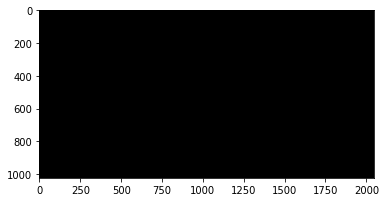

idx class:  1
nama class:  road


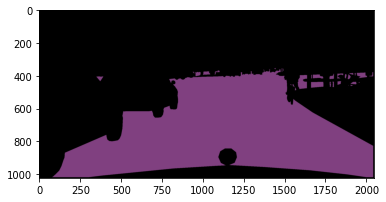

idx class:  2
nama class:  sidewalk


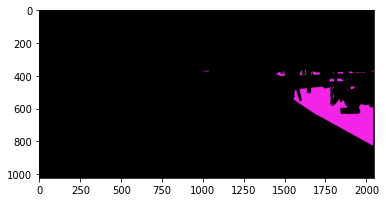

idx class:  3
nama class:  building


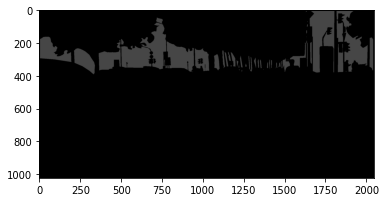

idx class:  4
nama class:  wall


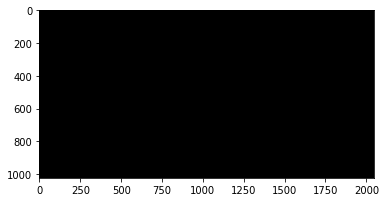

idx class:  5
nama class:  fence


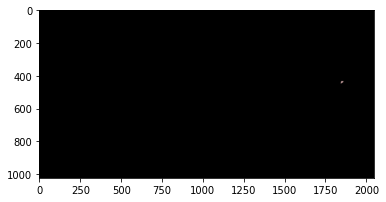

idx class:  6
nama class:  pole


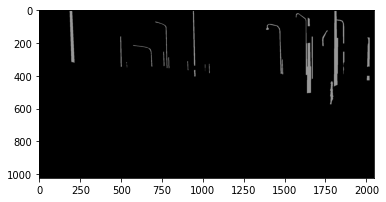

idx class:  7
nama class:  traffic light


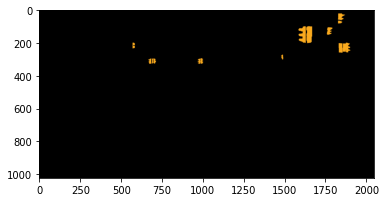

idx class:  8
nama class:  traffic sign


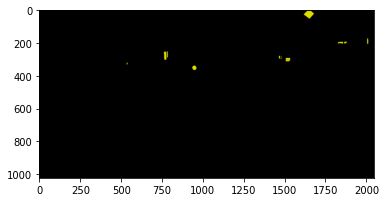

idx class:  9
nama class:  vegetation


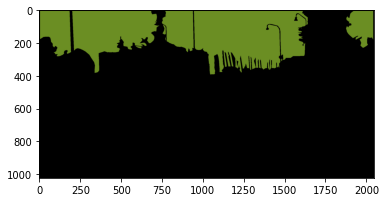

idx class:  10
nama class:  terrain


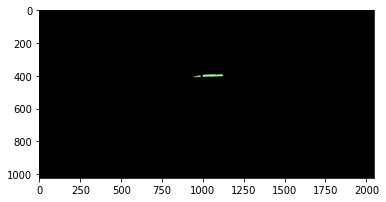

idx class:  11
nama class:  sky


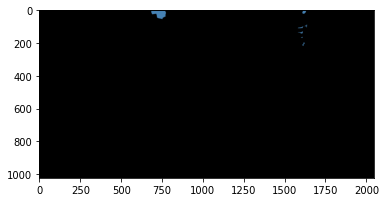

idx class:  12
nama class:  person


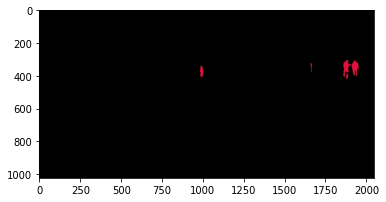

idx class:  13
nama class:  rider


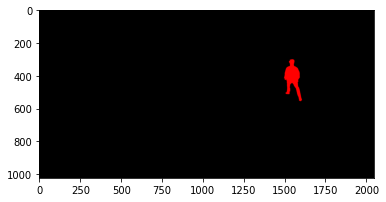

idx class:  14
nama class:  car


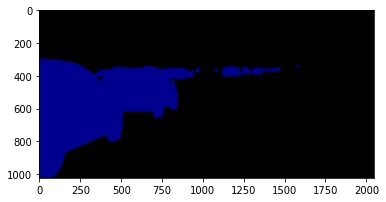

idx class:  15
nama class:  truck


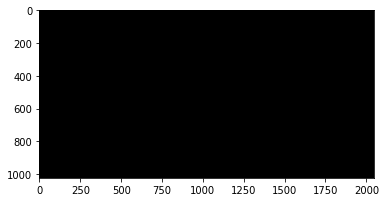

idx class:  16
nama class:  bus


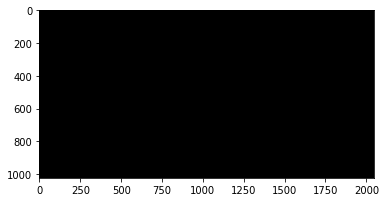

idx class:  17
nama class:  train


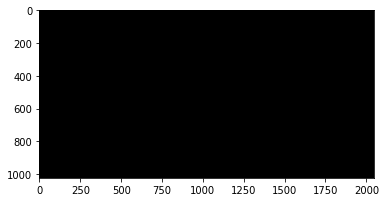

idx class:  18
nama class:  motorcycle


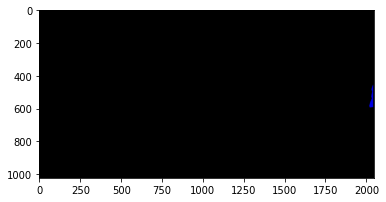

idx class:  19
nama class:  bicycle


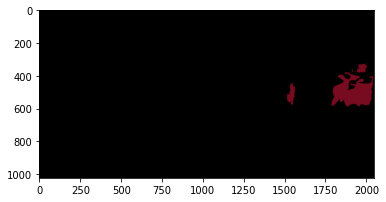

In [14]:
#konversi dari class id ke representasi one-hot encoding
def cls2one_hot(ss_gt20, n_class):
    one_hot = (np.arange(n_class) == ss_gt20[...,None]).astype(int) 
    return one_hot

print("shape GT segmentation yang telah dikonversi dari 35c ke 20c: ",seg_gtx.shape)
seg_one_hot = cls2one_hot(seg_gtx, n_class=len(SEG_MAP['classes']))
print("shape GT segmentation one hot encoded: ",seg_one_hot.shape)

for i in range(seg_one_hot.shape[2]):
    print('idx class: ',i)
    print('nama class: ',SEG_MAP['classes'][i])
    img_class_r = seg_one_hot[:, :, i:i+1] * SEG_MAP['colors'][i][0]
    img_class_g = seg_one_hot[:, :, i:i+1] * SEG_MAP['colors'][i][1]
    img_class_b = seg_one_hot[:, :, i:i+1] * SEG_MAP['colors'][i][2]
    img_class_rgb = np.concatenate([img_class_r, img_class_g, img_class_b], axis=2)
    plt.imshow(img_class_rgb.astype(np.uint8))
    plt.show()




MENDESAIN ARSITEKTUR UNET DAN DEEPLABV3
=====================


In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch import cat
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import segmentation #deeplabv3_resnet101

class ConvBNRelu(nn.Module):
    def __init__(self, channelx, stridex=1, kernelx=3, paddingx=1):
        super(ConvBNRelu, self).__init__()
        self.conv = nn.Conv2d(channelx[0], channelx[1], kernel_size=kernelx, stride=stridex, padding=paddingx, padding_mode='zeros')
        self.bn = nn.BatchNorm2d(channelx[1])
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x) 
        x = self.bn(x) 
        y = self.relu(x)
        return y

class ConvBlock(nn.Module):
    def __init__(self, channel, final=False): 
        super(ConvBlock, self).__init__()
        #conv block
        if final:
            self.conv_block0 = ConvBNRelu(channelx=[channel[0], channel[0]], stridex=1)
            self.conv_block1 = nn.Sequential(
            nn.Conv2d(channel[0], channel[1], kernel_size=1)
            )
        else:
            self.conv_block0 = ConvBNRelu(channelx=[channel[0], channel[1]], stridex=1)
            self.conv_block1 = ConvBNRelu(channelx=[channel[1], channel[1]], stridex=1)

 
    def forward(self, x):
        #convolutional block
        y = self.conv_block0(x)
        y = self.conv_block1(y)
        return y


class scratch_unet(nn.Module): #
    def __init__(self):
        super().__init__()
        #RGB
        self.conv1_rgb_f = ConvBlock(channel=[3, 32])
        self.conv0_rgb_f = ConvBlock(channel=[32, 64])

        #SEG
        self.conv1_ss_f = ConvBlock(channel=[64+32, 32])
        self.final_ss_f = ConvBlock(channel=[32, 23], final=True)
               
        #aktivasi final
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb):
        #bagian downsampling
        rgb_f_1 = self.conv1_rgb_f(rgb)
        down_rgb_f_1 = F.max_pool2d(rgb_f_1, kernel_size=(2,2))
        rgb_f_0 = self.conv0_rgb_f(down_rgb_f_1)
                
        #bagian upsampling
        up_rgb_f_0 = F.interpolate(rgb_f_0, size=rgb.size()[-2:], mode='bilinear', align_corners=True)
        ss_f_1 = self.conv1_ss_f(cat([up_rgb_f_0, rgb_f_1], dim=1))
        ss_f = self.sigmoid(self.final_ss_f(ss_f_1))
        
        return ss_f

print(scratch_unet())
    
    
class resunet_seg(nn.Module): #
    def __init__(self):
        super().__init__()
        n_fmap = [64, 64, 128, 256, 512]
        
        #RGB
        self.rgb_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.RGB_encoder = models.resnet34(pretrained=True) #resnet18
        self.RGB_encoder.fc = nn.Sequential() #cara paling gampang untuk menghilangkan fc layer yang tidak diperlukan
        self.RGB_encoder.avgpool = nn.Sequential() 

        #SEG
        self.conv3_ss_f = ConvBlock(channel=[n_fmap[4]+n_fmap[3], n_fmap[3]])
        self.conv2_ss_f = ConvBlock(channel=[n_fmap[3]+n_fmap[2], n_fmap[2]])
        self.conv1_ss_f = ConvBlock(channel=[n_fmap[2]+n_fmap[1], n_fmap[1]])
        self.conv0_ss_f = ConvBlock(channel=[n_fmap[1]+n_fmap[0], n_fmap[0]])
        self.final_ss_f = ConvBlock(channel=[n_fmap[0], 20], final=True)
                
        #aktivasi final
        self.sigmoid = nn.Sigmoid()

    def forward(self, rgb):
        #bagian downsampling
        in_rgb = self.rgb_normalizer(rgb)
        x_RGB = self.RGB_encoder.conv1(in_rgb)
        x_RGB = self.RGB_encoder.bn1(x_RGB)
        RGB_features0 = self.RGB_encoder.relu(x_RGB)
        RGB_features1 = self.RGB_encoder.layer1(self.RGB_encoder.maxpool(RGB_features0))
        RGB_features2 = self.RGB_encoder.layer2(RGB_features1)
        RGB_features3 = self.RGB_encoder.layer3(RGB_features2)
        RGB_features4 = self.RGB_encoder.layer4(RGB_features3)
        up_RGB_features4 = F.interpolate(RGB_features4, size=RGB_features3.size()[-2:], mode='bilinear', align_corners=True)
        
        #bagian segmentation
        ss_f_3 = self.conv3_ss_f(cat([up_RGB_features4, RGB_features3], dim=1))
        up_ss_f_3 = F.interpolate(ss_f_3, size=RGB_features2.size()[-2:], mode='bilinear', align_corners=True)
        ss_f_2 = self.conv2_ss_f(cat([up_ss_f_3, RGB_features2], dim=1))
        up_ss_f_2 = F.interpolate(ss_f_2, size=RGB_features1.size()[-2:], mode='bilinear', align_corners=True)
        ss_f_1 = self.conv1_ss_f(cat([up_ss_f_2, RGB_features1], dim=1))
        up_ss_f_1 = F.interpolate(ss_f_1, size=RGB_features0.size()[-2:], mode='bilinear', align_corners=True)
        ss_f_0 = self.conv0_ss_f(cat([up_ss_f_1, RGB_features0], dim=1))
        up_ss_f_0 = F.interpolate(ss_f_0, size=in_rgb.size()[-2:], mode='bilinear', align_corners=True)
        ss_f = self.sigmoid(self.final_ss_f(up_ss_f_0))
        
        return ss_f


print(resunet_seg())



class dlv3_seg(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.net = segmentation.deeplabv3_resnet101(pretrained=True) #pretrained di MS COCO 2017
        #ganti layer terakhir, point wise conv nya memiliki n_class=20
        self.net.classifier[4] = nn.Conv2d(256, 20, kernel_size=(1,1), stride=(1,1))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, rgb_f):
        in_rgb = self.rgb_normalizer(rgb_f)
        ss_f = self.sigmoid(self.net(in_rgb)['out'])

        return ss_f


print(dlv3_seg())

scratch_unet(
  (conv1_rgb_f): ConvBlock(
    (conv_block0): ConvBNRelu(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_block1): ConvBNRelu(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv0_rgb_f): ConvBlock(
    (conv_block0): ConvBNRelu(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv_block1): ConvBNRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (

/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resunet_seg(
  (rgb_normalizer): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (RGB_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dlv3_seg(
  (rgb_normalizer): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (net): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2

MEMBUAT FUNGSI-FUNGSI PENDUKUNG
=====================


A. DATALOADER DAN FUNGSI PENDUKUNGNYA
----------------


In [16]:
from torch.utils.data import Dataset

#Define colormap dan konversi label dari 35 class ke 20 class
#BACA https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
SEG_MAP = {
    'colors'        :[[0, 0, 0], [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],  
                    [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
                    [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
                    [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], 
                    [0, 80, 100], [0, 0, 230], [119, 11, 32]],  
    'classes'       : ['None', 'road', 'sidewalk', 'building', 'wall',
                        'fence', 'pole', 'traffic light', 'traffic sign', 
                        'vegetation', 'terrain', 'sky', 'person', 
                        'rider', 'car', 'truck', 'bus',
                        'train', 'motorcycle', 'bicycle'],
}

mapping_20 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 2,
        9: 0,
        10: 0,
        11: 3,
        12: 4,
        13: 5,
        14: 0,
        15: 0,
        16: 0,
        17: 6,
        18: 0,
        19: 7,
        20: 8,
        21: 9,
        22: 10,
        23: 11,
        24: 12,
        25: 13,
        26: 14,
        27: 15,
        28: 16,
        29: 0,
        30: 0,
        31: 17,
        32: 18,
        33: 19,
        -1: 0
    }


#konversi dari 35 class ke 20 class
def encode_labels(mask, mapping_label):
    #inputnya adalah HWC hasil baca opencv
    mask = mask[:,:,0:1].reshape(mask.shape[0], mask.shape[1])  #ambil 1 channel dan reshape dari 3D ke 2D
    label_mask = np.zeros_like(mask)
    for k in mapping_label:
        label_mask[mask == k] = mapping_label[k]
    return label_mask

#konversi dari class id ke representasi one-hot encoding
def cls2one_hot(ss_gt20, n_class):
    one_hot = (np.arange(n_class) == ss_gt20[...,None]).astype(int) 
    return one_hot


#untuk mereduksi dimensi spasial supaya komputasi tidak terlalu berat
def resize_matrix(image, resize):
    #inputnya HWC
    WH_resized = (int(image.shape[1]/resize), int(image.shape[0]/resize))
    resized_image = cv2.resize(image, WH_resized, interpolation=cv2.INTER_NEAREST)

    return resized_image


#buat class dataset
class myData(Dataset):
    def __init__(self, root_dir, part):
        #buat list kosong dulu
        self.rgb = []
        self.seg = []
        
        #define folder masing2 untuk rgb seg dep
        rgb_folder = os.path.join(os.path.join(os.path.join(root_dir, 'leftImg8bit_trainvaltest'), 'leftImg8bit'), part)
        seg_folder = os.path.join(os.path.join(os.path.join(root_dir, 'gtFine_trainvaltest'), 'gtFine'), part)
 
        # list semua kota yang ada di RGB leftimg8bit
        town_list = os.listdir(rgb_folder)
        town_list.sort()
        for town in town_list:
            rgb_dir = os.path.join(rgb_folder, town)
            seg_dir = os.path.join(seg_folder, town)
            
            #list semua file
            file_list = os.listdir(rgb_dir)
            file_list.sort()
            for filename in file_list:
                #append ke list kosong tadi
                self.rgb.append(os.path.join(rgb_dir, filename))
                self.seg.append(os.path.join(seg_dir, filename[:-15]+'gtFine_labelIds.png'))

    def __len__(self):
        return len(self.rgb)

    def __getitem__(self, index):
        data = dict()
        data['rgb'] = np.transpose(np.array(resize_matrix(
            cv2.imread(self.rgb[index]), 
            resize=4)), (2, 0, 1)) # (H, W, C) --> (C, H, W)
        data['seg'] = np.transpose(np.array(resize_matrix(cls2one_hot(encode_labels(
            cv2.imread(self.seg[index]), 
            mapping_label=mapping_20), n_class=len(SEG_MAP['classes'])), resize=4)), (2, 0, 1)) # (H, W, C) --> (C, H, W)

        return data
    

B. TRAINING-VALIDATION
----------------


In [24]:
#!pip install --upgrade ipywidgets
from tqdm.notebook import tqdm

#Class untuk penyimpanan dan perhitungan update loss
class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    #update kalkulasi
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

#FUNGSI TRAINING
def train(data_loader, model, writer, cur_epoch, device, optimizer):
    #buat variabel untuk menyimpan kalkulasi loss
    loss_total = AverageMeter()
    loss_seg = AverageMeter()

    #masuk ke mode training, pytorch
    model.train()

    #visualisasi progress training dengan tqdm
    prog_bar = tqdm()
    prog_bar.reset(total=len(data_loader))

    #training....
    total_batch = len(data_loader)
    batch_ke = 0
    for data in data_loader:
        cur_step = cur_epoch*total_batch + batch_ke

        seg_gt = data['seg'].to(device, dtype=torch.float)
        image = data['rgb'].to(device, dtype=torch.float)

        #forward pass
        pred_seg = model(image)

        #kalkulasi loss
        bce_loss = F.binary_cross_entropy(pred_seg, seg_gt) 
        total_loss = bce_loss

        #backpro, kalkulasi gradient, dan update bobot2 pada network model
        optimizer.zero_grad()
        total_loss.backward() 
        optimizer.step()

        #hitung rata-rata (avg) loss, dan metric untuk batch-batch yang telah diproses
        loss_total.update(total_loss.item())
        loss_seg.update(bce_loss.item())

        #update visualisasi progress bar
        postfix = OrderedDict([('train_loss_total', loss_total.avg),
                               ('train_loss_seg', loss_seg.avg)])

        #tambahkan ke summary writer
        writer.add_scalar('train_loss_total', total_loss.item(), cur_step)
        writer.add_scalar('train_loss_seg', bce_loss.item(), cur_step)

        prog_bar.set_postfix(postfix)
        prog_bar.update()
        batch_ke += 1
    prog_bar.refresh()

    return postfix


#FUNGSI VALIDATION
def validate(data_loader, model, writer, cur_epoch, device):
    #buat variabel untuk menyimpan kalkulasi loss
    loss_total = AverageMeter()
    loss_seg = AverageMeter()

    #masuk ke mode eval, pytorch
    model.eval()
    
    with torch.no_grad():
        #visualisasi progress training dengan tqdm
        prog_bar = tqdm()
        prog_bar.reset(total=len(data_loader))

        #training....
        total_batch = len(data_loader)
        batch_ke = 0
        for data in data_loader:
            cur_step = cur_epoch*total_batch + batch_ke

            seg_gt = data['seg'].to(device, dtype=torch.float)
            image = data['rgb'].to(device, dtype=torch.float)

            #forward pass
            pred_seg = model(image)

            #kalkulasi loss
            bce_loss = F.binary_cross_entropy(pred_seg, seg_gt) 
            total_loss = bce_loss

            #backpro, kalkulasi gradient, dan update bobot2 pada network model
    #         optimizer.zero_grad()
    #         total_loss.backward() 
    #         optimizer.step()

            #hitung rata-rata (avg) loss, dan metric untuk batch-batch yang telah diproses
            loss_total.update(total_loss.item())
            loss_seg.update(bce_loss.item())

            #update visualisasi progress bar
            postfix = OrderedDict([('val_loss_total', loss_total.avg),
                                   ('val_loss_seg', loss_seg.avg)])

            #tambahkan ke summary writer
            writer.add_scalar('val_loss_total', total_loss.item(), cur_step)
            writer.add_scalar('val_loss_seg', bce_loss.item(), cur_step)

            prog_bar.set_postfix(postfix)
            prog_bar.update()
            batch_ke += 1
        prog_bar.refresh()

    return postfix



TRAIN-VAL-TEST MODEL
=====================


A. KONFIGURASI TRAINING-VALIDATION
----------------

In [19]:
from torch import torch
from collections import OrderedDict
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import pandas as pd
import os

#IMPORT MODEL UNTUK DITRAIN
model = resunet_seg() #scratch_unet resunet_seg dlv3_seg

#KONFIGURASI OPTIMIZER
optima = optim.Adam(model.parameters(), lr=0.0025)
n_epoch = 1
lr_sch = optim.lr_scheduler.CosineAnnealingLR(optima, T_max=n_epoch, eta_min=0.0001)


#BUAT DATA BATCH: NxCxHxW
rootdir = "/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/"
train_set = myData(root_dir=rootdir, part='train')
val_set = myData(root_dir=rootdir, part='val')
print("Jumlah sample training: "+str(len(train_set)))
print("Jumlah sample validation: "+str(len(val_set)))
dataloader_train = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=4) 
dataloader_val = DataLoader(val_set, batch_size=5, shuffle=False, num_workers=4)

#buat dictionary log untuk menyimpan training log di CSV dan tensorboard
save_dir = os.getcwd() +"/resunet_seg/"
os.makedirs(save_dir, exist_ok=True)
log = OrderedDict([
    ('epoch', []),
    ('val_loss_total', []),
    ('val_loss_seg', []),
    ('train_loss_total', []),
    ('train_loss_seg', []),
    ('elapsed_time', [])])
writer = SummaryWriter(save_dir)

/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Jumlah sample training: 2975
Jumlah sample validation: 500


B. SET DEVICE DAN PLOT MODEL
----------------

In [20]:
#setting device dan inspect arsitektur
import os
import time
from torch import torch, nn
from torchviz import make_dot
from torchsummary import summary


#SET Device yang akan dipakai
device = torch.device("cuda") #cuda cpu
print(device)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.device_count() > 1:
    print("Available GPU =", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
    model = nn.DataParallel(model) 
else:
    print("Available GPU =", torch.cuda.device_count())
    print(torch.cuda.get_device_name())
model = model.to(device, dtype=torch.float)


#visualisasi model
#buat dummy tensor dulu: batch x channel x H x W
X_in = torch.zeros(1, 3, 300, 400, dtype=torch.float, requires_grad=False, device=device)
#inference 1x dan ambil graph arsitekturnya
Y_out = model(X_in)
model_graph = make_dot(Y_out[0])
model_graph.format = 'png'
model_graph.render(save_dir+"model_graph")

#visualize arsitektur di tensorboard
summary(model,input_size=X_in[0].size())
writer.add_graph(model, X_in) #visualisasi model harus dengan 1 GPU saja.
# writer.close()

cuda
Available GPU = 1
NVIDIA GeForce GTX 1080 Ti
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1          [-1, 3, 300, 400]               0
            Conv2d-2         [-1, 64, 150, 200]           9,408
       BatchNorm2d-3         [-1, 64, 150, 200]             128
              ReLU-4         [-1, 64, 150, 200]               0
         MaxPool2d-5          [-1, 64, 75, 100]               0
            Conv2d-6          [-1, 64, 75, 100]          36,864
       BatchNorm2d-7          [-1, 64, 75, 100]             128
              ReLU-8          [-1, 64, 75, 100]               0
            Conv2d-9          [-1, 64, 75, 100]          36,864
      BatchNorm2d-10          [-1, 64, 75, 100]             128
             ReLU-11          [-1, 64, 75, 100]               0
       BasicBlock-12          [-1, 64, 75, 100]               0
           Conv2d-13          [-1, 64, 75, 100]      

C. MULAI TRAINING DAN VALIDATION
----------------

In [25]:
#define loss terkecil
lowest_loss = float('inf')
for epoch in range(n_epoch): #ulang sebanyak n epoch
    print("Epoch: {:05d}------------------------------------------------".format(epoch))
    print("current lr untuk training: ", optima.param_groups[0]['lr'])
    
    start_time = time.time() #waktu mulai
    train_log = train(dataloader_train, model, writer, epoch, device, optima)
    val_log = validate(dataloader_val, model, writer, epoch, device)
    lr_sch.step() #update learning rate
    
    #save best model saja
    if val_log['val_loss_total'] < lowest_loss:
        print("best model disave!")
        torch.save(model.state_dict(), save_dir+'model.pth')
        lowest_loss = val_log['val_loss_total']
    elapsed_time = time.time() - start_time #hitung elapsedtime
    
    print(train_log)
    print(val_log)
    print(elapsed_time)
    
    log['epoch'].append(epoch)
    log['val_loss_total'].append(val_log['val_loss_total'])
    log['val_loss_seg'].append(val_log['val_loss_seg'])
    log['train_loss_total'].append(train_log['train_loss_total'])
    log['train_loss_seg'].append(train_log['train_loss_seg'])
    log['elapsed_time'].append(elapsed_time)
    pd.DataFrame(log).to_csv(save_dir+'trainval_log.csv', index=False)
    
    epoch += 1
    
torch.cuda.empty_cache()

Epoch: 00000------------------------------------------------
current lr untuk training:  0.0025


0it [00:00, ?it/s]

0it [00:00, ?it/s]

best model disave!
OrderedDict([('train_loss_total', 0.08218279774574673), ('train_loss_seg', 0.08218279774574673)])
OrderedDict([('val_loss_total', 0.06433294370770454), ('val_loss_seg', 0.06433294370770454)])
286.72301983833313


D. TEST MODEL
----------------

/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/
/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/gtFine_trainvaltest/gtFine/


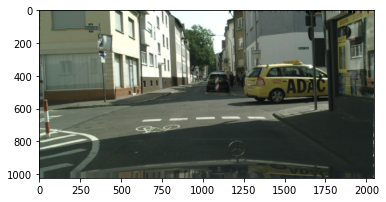

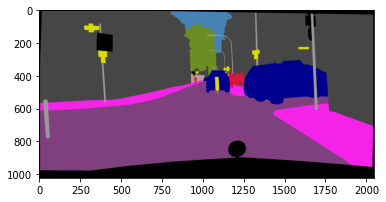

In [26]:
rootdir = "/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/"
dir_rgb = rootdir+"leftImg8bit_trainvaltest/leftImg8bit/"
dir_seg = rootdir+"gtFine_trainvaltest/gtFine/"
part = 'val/' #train val test
town = 'frankfurt/' #pilih salah satu kota

print(dir_rgb)
print(dir_seg)

#------------------------------------------------
#load input dan outputnya

#RGB
#list semua file yang ada pada salah satu town di direktori RGB
list_file = os.listdir(dir_rgb+part+town)
list_file.sort() #urutkan
idx = 0
filename = list_file[idx] #ambil salah satu file
image = cv2.imread(dir_rgb+part+town+filename)
imagex = image[:, :, [2, 1, 0]]

#SEG
#list semua file yang ada pada salah satu town di direktori SEG
list_file = os.listdir(dir_seg+part+town)
list_file.sort() #urutkan
idx = 0
idx = 5*idx + 2
filename = list_file[idx] #ambil salah satu file
seg_gt = cv2.imread(dir_seg+part+town+filename)


#visualisasi image
plt.imshow(imagex)
plt.show()

#visualisasi GT segmentasi
seg_gtx = encode_labels(seg_gt, mapping_20)
seg_color = vis_seg(seg_gtx, SEG_MAP)
plt.imshow(seg_color.astype(np.uint8))
plt.show()


/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/aisl/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


input image shape torch.Size([1, 3, 256, 512])
output prediction shape (256, 512)


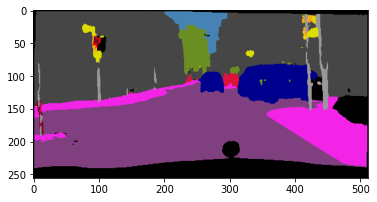

In [29]:
#PREDIKSI
# model = resunet_seg() #resunet_seg dlv3_seg
# model.load_state_dict(torch.load(save_dir+'best_model.pth'))
# model.to(device, dtype=torch.float)
input_img = np.expand_dims(resize_matrix(image, resize=4).transpose(2,0,1), axis=0) #buat jadi NxCxHxW
input_img = torch.from_numpy(input_img).to(device, dtype=torch.float)
print("input image shape", input_img.size())
pred_seg = model(input_img)
pred_seg = np.argmax(pred_seg.cpu().detach().numpy()[0], axis=0) #ambil batch 0 dan lakukan argmax
print("output prediction shape", pred_seg.shape)


#visualisasi prediksi segmentasi
pseg_color = vis_seg(pred_seg, SEG_MAP)
plt.imshow(pseg_color.astype(np.uint8))
plt.show()

E. TEST KE SELURUH SAMPLE
----------------

In [30]:
#FUNGSI IOU
def IOU(Yp, Yt):
    #.view(-1) artinya matrix tensornya di flatten kan dulu
    output = Yp.view(-1) > 0.5 #maksudnya yang lebih dari 0.5 adalah true
    target = Yt.view(-1) > 0.5 #dan yang kurang dari 0.5 adalah false
    intersection = (output & target).sum() #irisan
    union = (output | target).sum() #union
    #rumus IoU
    iou = intersection / union
    return iou

#FUNGSI TEST
def test(data_loader, model, device):
    #buat variabel untuk menyimpan kalkulasi loss
    metric_tm = AverageMeter()
    metric_seg = AverageMeter()
    
    #buat dictionary log untuk menyimpan training log di CSV
    logx = OrderedDict([
        ('batch', []),
        ('test_tm', []),
        ('test_seg', []),
        ('elapsed_time', [])])

    #masuk ke mode eval torch
    model.eval()
    
    with torch.no_grad():
        #visualisasi progress training dengan tqdm
        prog_bar = tqdm()
        prog_bar.reset(total=len(data_loader))

        #training....
        total_batch = len(data_loader)
        batch_ke = 0
        for data in data_loader:
            seg_gt = data['seg'].to(device, dtype=torch.float)
            image = data['rgb'].to(device, dtype=torch.float)

            #forward pass
            start_time = time.time() #waktu mulai
            pred_seg = model(image)
            elapsed_time = time.time() - start_time #hitung elapsedtime

            #kalkulasi metric
            iou = IOU(pred_seg, seg_gt)
            tm = (1-iou)
            
            #hitung rata-rata (avg) loss, dan metric untuk batch-batch yang telah diproses
            metric_tm.update(tm.item())
            metric_seg.update(iou.item())

            #update visualisasi progress bar
            postfix = OrderedDict([('tm', metric_tm.avg),
                                  ('iou', metric_seg.avg)])
            
            #simpan ke log
            logx['batch'].append(batch_ke)
            logx['test_tm'].append(tm.item())
            logx['test_seg'].append(iou.item())
            logx['elapsed_time'].append(elapsed_time)
            pd.DataFrame(logx).to_csv(save_dir+'test_log.csv', index=False)
            
            batch_ke += 1  
            prog_bar.set_postfix(postfix)
            prog_bar.update()
        prog_bar.refresh()
        
        #ketika semua sudah selesai, hitung rata2 performa pada log
        logx['batch'].append("avg")
        logx['test_tm'].append(np.mean(logx['test_tm']))
        logx['test_seg'].append(np.mean(logx['test_seg']))
        logx['elapsed_time'].append(np.mean(logx['elapsed_time']))
        pd.DataFrame(logx).to_csv(save_dir+'test_log.csv', index=False)

    return postfix


#BUAT DATA BATCH: NxCxHxW
rootdir = "/home/aisl/BISA_AI/ai-hw-acc/dataset/cityscapes/"
test_set = myData(root_dir=rootdir, part='val')
print("Jumlah sample test: "+str(len(test_set)))
dataloader_test = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4)

start_time = time.time() #waktu mulai
test_log = test(dataloader_test, model, device)
elapsed_time = time.time() - start_time #hitung elapsedtime
print(test_log)
print(elapsed_time)
torch.cuda.empty_cache()

Jumlah sample test: 500


0it [00:00, ?it/s]

OrderedDict([('tm', 0.1751321575641632), ('iou', 0.8248678424954414)])
41.66574740409851
